In [67]:
import pandas as pd
from pre_processing import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

## Data processing
Load data in a single dataframe and split into train and test

In [68]:
PATH = './Train/Train'

df = load_general(PATH)

df_train, df_test = train_test_split(df)

has_nan(df_train)

(True,
 station                           0
 latitude                          0
 longitude                         0
 numDocks                          0
 timestamp                         0
 year                              0
 month                             0
 day                               0
 hour                              0
 weekday                           0
 weekhour                          0
 isHoliday                         0
 windMaxSpeed.m.s                 54
 windMeanSpeed.m.s                54
 windDirection.grades            295
 temperature.C                    54
 relHumidity.HR                   54
 airPressure.mb                   54
 precipitation.l.m2               54
 bikes_3h_ago                    217
 full_profile_3h_diff_bikes     9567
 full_profile_bikes             9414
 short_profile_3h_diff_bikes    9567
 short_profile_bikes            9414
 bikes                            54
 dtype: int64)

Perform data processing and basic feature selection

In [69]:
#drop instance where there's no number of bikes
df_train = drop_nan_bikes(df_train)
df_test = drop_nan_bikes(df_test)

# #replaces days with numbers
df_train = day_transform(df_train)
df_test = day_transform(df_test)

#replaces NaN with median
# df_train = nan_impute(df_train)
# df_test = nan_impute(df_test)

# #removes features with zero variance
df_train = var_transform(df_train)
df_test = var_transform(df_test)

# #has_nan(df_test)
#
df_test

,station,latitude,longitude,numDocks,timestamp,day,hour,weekday,weekhour,isHoliday,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
33087,243,39.463572,-0.329886,19,1.413220e+09,13,19,1,20,0,22.5,12.9,180.0,23.0,43.0,1009.1,15.0,-4.000000,13.000000,-4.000000,13.000000,6.0
14288,242,39.467937,-0.331817,15,1.412593e+09,6,13,1,14,0,11.3,3.2,225.0,25.6,63.0,1011.7,7.0,NaN,NaN,NaN,NaN,9.0
48600,238,39.473169,-0.380298,15,1.412744e+09,8,7,3,56,0,9.7,4.8,202.5,19.6,67.0,1011.1,0.0,1.000000,1.000000,1.000000,1.000000,0.0
21417,259,39.465639,-0.396839,15,1.414120e+09,24,5,5,102,0,1.6,0.0,180.0,18.3,47.0,1017.3,9.0,-0.333333,7.000000,-0.333333,7.000000,9.0
50647,222,39.461261,-0.347921,20,1.414750e+09,31,11,5,108,0,11.3,3.2,45.0,21.3,71.0,1025.1,10.0,-3.750000,3.500000,-3.750000,3.500000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28562,270,39.445428,-0.393106,20,1.413022e+09,11,12,6,133,0,3.2,0.0,337.5,24.6,54.0,1013.1,16.0,-1.000000,10.000000,-1.000000,10.000000,18.0
20727,223,39.467747,-0.358505,20,1.414318e+09,26,11,7,156,0,14.5,6.4,67.5,21.6,78.0,1023.6,0.0,-2.000000,2.333333,-2.000000,2.333333,0.0
16098,219,39.459311,-0.348777,25,1.413745e+09,19,21,7,166,0,3.2,0.0,22.5,21.3,88.0,1024.9,25.0,0.500000,18.000000,0.500000,18.000000,21.0
41305,214,39.467333,-0.365119,20,1.413302e+09,14,18,2,43,0,17.7,6.4,180.0,21.7,41.0,1005.8,16.0,-5.000000,2.000000,-5.000000,2.000000,5.0


Find which feature has highest correlation with bikes

In [70]:
corr_matrix = correl(df_train)
print(corr_matrix['bikes'].sort_values(ascending=False).head(10))

bikes                          1.000000
bikes_3h_ago                   0.673236
short_profile_bikes            0.652644
full_profile_bikes             0.652644
longitude                      0.284092
short_profile_3h_diff_bikes    0.259499
full_profile_3h_diff_bikes     0.259499
latitude                       0.194761
numDocks                       0.119047
hour                           0.029506
Name: bikes, dtype: float64


<AxesSubplot:xlabel='short_profile_3h_diff_bikes', ylabel='bikes'>

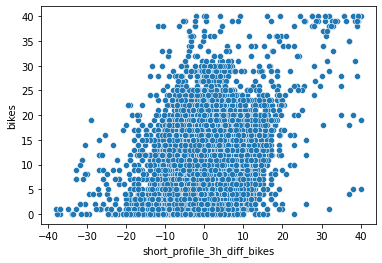

In [71]:
sns.scatterplot(data=df_train, x='short_profile_3h_diff_bikes', y='bikes')

Find inter-feature correlation and drop features with a correlation higher than 0.95

Obviously windmean and windmax are positively correlated.

['day', 'weekhour', 'windMeanSpeed.m.s', 'short_profile_3h_diff_bikes', 'short_profile_bikes']


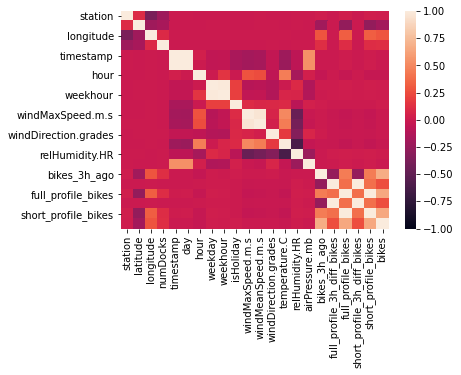

In [72]:
sns.heatmap(df_train.corr(), vmin=-1.0, vmax=1.0)

dropped = high_correl(df_train, 0.95)
dropped = high_correl(df_test, 0.95)
print(dropped)

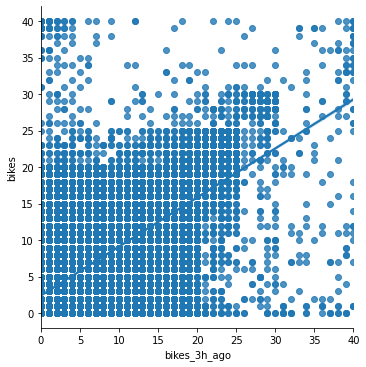

In [73]:
sns.lmplot(data= df_train, x='bikes_3h_ago', y='bikes')

Plot histograms to see whether input is Gaussian

array([[<AxesSubplot:title={'center':'station'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'numDocks'}>],
       [<AxesSubplot:title={'center':'timestamp'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'weekday'}>,
        <AxesSubplot:title={'center':'isHoliday'}>],
       [<AxesSubplot:title={'center':'windMaxSpeed.m.s'}>,
        <AxesSubplot:title={'center':'windDirection.grades'}>,
        <AxesSubplot:title={'center':'temperature.C'}>,
        <AxesSubplot:title={'center':'relHumidity.HR'}>],
       [<AxesSubplot:title={'center':'airPressure.mb'}>,
        <AxesSubplot:title={'center':'bikes_3h_ago'}>,
        <AxesSubplot:title={'center':'full_profile_3h_diff_bikes'}>,
        <AxesSubplot:title={'center':'full_profile_bikes'}>],
       [<AxesSubplot:title={'center':'bikes'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=ob

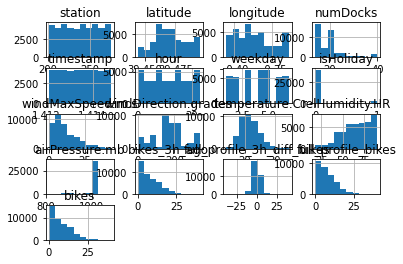

In [74]:
df_train.hist()

Let's now investigate some categorical features

<AxesSubplot:xlabel='weekday', ylabel='bikes'>

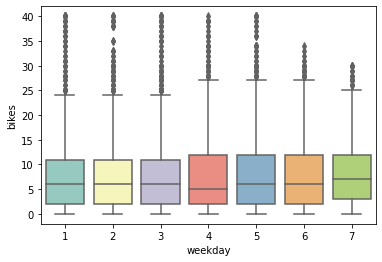

In [75]:
#sns.set_style('darkgrid')
#f, axes = plt.subplots(2,2, figsize = (15,15))
sns.boxplot(data = df_train, x = 'weekday', y = 'bikes', palette="Set3")

<AxesSubplot:xlabel='isHoliday', ylabel='bikes'>

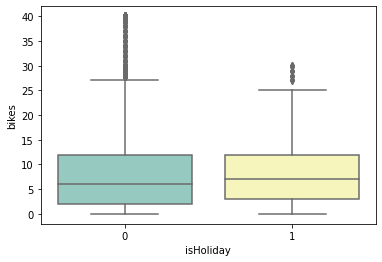

In [76]:
sns.boxplot(data = df_train, x = 'isHoliday', y = 'bikes', palette="Set3")

<AxesSubplot:xlabel='hour', ylabel='bikes'>

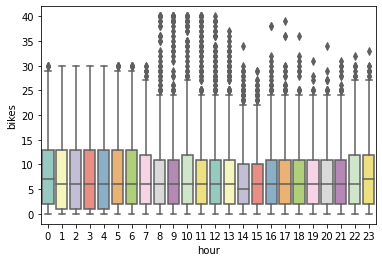

In [77]:
sns.boxplot(data = df_train, x = 'hour', y = 'bikes', palette="Set3")

## Model selection

Scale the features and impute missing data

In [78]:
#store features and target in two different dataframes
X_train = df_train.loc[:, df_train.columns != 'bikes']
Y_train = df_train['bikes']

In [98]:
X_train

,station,latitude,longitude,numDocks,timestamp,hour,weekday,isHoliday,windMaxSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes
0,0.026316,-0.390373,0.365507,0.0,-0.444744,0.250000,0.00,1.0,1.274336,0.000000,2.000,-1.074074,-0.457627,1.0,-1.500000,-0.484848
1,0.315789,-1.338019,-0.114527,-0.4,-0.568733,0.416667,-0.50,0.0,1.707965,1.333333,2.200,-1.259259,-0.525424,0.9,-0.215246,0.919811
2,0.710526,1.413032,-0.665914,0.0,-0.590296,-0.250000,-0.50,0.0,0.424779,0.333333,-0.275,-0.333333,-0.389831,-0.6,0.632235,-0.172742
3,0.500000,-0.471912,-0.636049,-1.0,0.773585,-0.166667,-0.50,0.0,-0.575221,-0.333333,-0.475,0.370370,0.245763,-0.2,-1.400000,-0.242424
4,-0.894737,0.251869,0.154433,1.0,0.870620,0.833333,-0.25,0.0,-0.433628,-1.666667,-0.500,0.666667,0.389831,0.9,-1.050000,-0.515152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41847,0.947368,0.604340,1.133649,-1.0,0.571429,-0.333333,0.50,0.0,-0.150442,0.666667,-0.950,-0.629630,0.338983,0.9,-0.200000,0.929293
41848,-0.894737,0.251869,0.154433,1.0,-0.169811,0.750000,-0.75,0.0,0.991150,0.000000,0.175,-0.925926,-0.516949,-0.5,-1.500000,-0.727273
41849,0.605263,0.048584,-0.557899,-1.0,0.382749,-0.166667,-0.25,0.0,0.849558,-0.333333,0.450,-1.222222,0.694915,0.1,-1.600000,-0.686869
41850,-0.342105,-0.619467,1.014089,-1.2,0.388140,0.000000,-0.25,0.0,0.000000,0.000000,1.125,-1.629630,0.728814,0.4,-0.300000,-0.080808


In [79]:
#scaled test set
# scaled_X_test = scaled_df_test.loc[:, df_test.columns != 'bikes']
# scaled_Y_test= scaled_df_test['bikes']

#unscaled test set (to see predictions)
X_test = df_test.loc[:, df_test.columns != 'bikes']
Y_test= df_test['bikes']

In [80]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'scaler.joblib')

imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


Experiment with baseline methods

In [87]:
# pipelines = [('Linear regression', Pipeline([('Scaler', MinMaxScaler()), ("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('LR',LinearRegression())])),
#              ('Ridge', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('L2',Ridge())])),
#              ('DecisionTree',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('DT',DecisionTreeRegressor())])),
#              ('RandomForest',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('RF',RandomForestRegressor())])),
#              ('KNN',Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('KNN',KNeighborsRegressor())])),
#            #  ('SVR',Pipeline([('Scaler', RobustScaler()),('SVR',SVR())])),
#              ('GradientBoosting', Pipeline([('Scaler', MinMaxScaler()),("Imputer", KNNImputer(missing_values=np.nan,
#                                                                                                 n_neighbors=5, weights='distance')),('GBM', GradientBoostingRegressor())]))]

pipelines = [('LR',LinearRegression()),
             ('L2',Ridge()),
             ('DT',DecisionTreeRegressor()),
             ('RF',RandomForestRegressor()),
             ('KNN',KNeighborsRegressor()),
             ('SVR',SVR()),
             ('GBM', GradientBoostingRegressor())]

#shuffle the data to preserve generality (avoids overfitting)
#df[i] = shuffle(df[i])

for model, pipeline in pipelines:
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f'Model {model} : {cv_scores.mean()}\n')

print("\n")

Model LR : -2.8907749211793763

Model L2 : -2.8908275235724425

Model DT : -3.176358760909649



KeyboardInterrupt: 

As it is possible to see RandomForest and SVR are the ones that perform better. Let's try to tune Random Forest first

In [88]:
param_grid_forest = {'n_estimators': np.arange(100, 2000, 500),
          'max_features': ['auto', 'sqrt'],
          'max_depth': [np.arange(5, 100, 19), None],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4]
         }

tree_reg = RandomizedSearchCV(estimator = RandomForestRegressor(),
                              param_distributions = param_grid_forest, n_iter = 20,
                              verbose = 2, n_jobs = -2, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
tree_reg.fit(X_train, Y_train)
joblib.dump(tree_reg.best_estimator_, "randomforest.joblib")
print(f'Best parameters for dataset are {tree_reg.best_params_}')
print(f'Best score is {tree_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for dataset are {'n_estimators': 1100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best score is -2.2713239779807863


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed: 18.5min finished


In [89]:
forest = joblib.load("randomforest.joblib")
predictions = forest.predict(X_test)
#predictions = tree_reg.best_estimator_.predict(X_test)
# test_error = mean_absolute_error(predictions, Y_test)
# print(f"The MAE on the test set is {test_error}\n")
#
#
# sorted(dict(zip(X_train.columns, tree_reg.best_estimator_.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

In [95]:
prediction = pd.DataFrame(predictions, columns=['bikes'], dtype='int32')
mean_absolute_error(prediction, Y_test)

2.2494264410668197

In [96]:
prediction

,bikes
0,11
1,7
2,1
3,9
4,4
...,...
13943,15
13944,2
13945,22
13946,9


In [97]:
Y_test

33087     6.0
14288     9.0
48600     0.0
21417     9.0
50647     3.0
         ... 
28562    18.0
20727     0.0
16098    21.0
41305     5.0
28318     9.0
Name: bikes, Length: 13948, dtype: float64

We got an accuracy of nearly 79% on the test set.

Now tune Support Vector Machine Regressor

In [241]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.values.astype(np.float))
# Y_train = scaler.fit_transform(Y_train.values.astype(np.float).reshape(-1, 1))

param_grid_kernel = {#'kernel': ['poly', 'rbf', 'sigmoid'],
                     #'epsilon': np.arange(0.1, 1.0, 0.1),
                     'gamma': [0.01, 0.1, 0.5, 1],
                     'C': [0.1, 1, 10, 100]
                       }
#pipe = make_pipeline(StandardScaler(), SVR())
svr_reg = GridSearchCV(estimator=SVR(),
                        param_grid = param_grid_kernel, #n_iter = 10,
                        verbose = 3, n_jobs = -3, cv=5, scoring='neg_mean_absolute_error')
print(f"Starting training...")
svr_reg.fit(X_train, Y_train)
joblib.dump(svr_reg.best_estimator_, "svr.joblib")
print(f'Best parameters for dataset are {svr_reg.best_params_}')
print(f'Best score is {svr_reg.best_score_}')

Starting training...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:  6.6min


KeyboardInterrupt: 

In [29]:
X_train

array([[241.        ,  39.46984411,  -0.32964496, ...,   3.        ,
          1.5       ,  11.5       ],
       [233.        ,  39.47854813,  -0.342366  , ...,   4.        ,
          0.        ,   6.25      ],
       [237.        ,  39.48567015,  -0.37859211, ...,   0.        ,
         11.        ,  12.        ],
       ...,
       [208.        ,  39.46905609,  -0.3757281 , ...,  29.        ,
         -8.25      ,  18.75      ],
       [268.        ,  39.45947405,  -0.40283117, ...,  11.        ,
          0.        ,   1.        ],
       [205.        ,  39.47078409,  -0.38270112, ...,   5.        ,
          1.5       ,   1.5       ]])